# Twitter sentiment analysis

In this notebook we shall see different NLP techniques we have learnt so far to detect the hate speech in tweets.

This notebook is taken from the [link](https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec/notebook).

**What is Sentiment Analysis?**

Sentiment analysis (also known as opinion mining) is one of the many applications of Natural Language Processing. It is a set of methods and techniques used for extracting subjective information from text or speech, such as opinions or attitudes. In simple terms, it involves classifying a piece of text as positive, negative or neutral.

![Imgur](https://i.imgur.com/n2MmZrY.png)
<!-- <img src="subdirect****ory/MyImage.png",width=60,height=60> -->

The objective of this task is to **detect hate speech in tweets**. 

For the sake of simplicity, we say *a tweet contains hate speech if it has a racist or sexist sentiment associated with it.* 

So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

#### Table of contents

1. Understand the Problem Statement
1. Tweets Preprocessing and Cleaning
    1. Data Inspection
    1. Data Cleaning
1. Visualization from Tweets
1. Extracting Features from Cleaned Tweets
    1. Bag-of-Words
    1. TF-IDF
    1. Word Embeddings
1. Model Building: Sentiment Analysis
    1. Logistic Regression
    1. Support Vector Machine
    1. RandomForest
    1. XGBoost
1. Model Fine-tuning
1. Conclusion

In [1]:
# Let’s load the libraries

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
# Let’s read train and test datasets.

train  = pd.read_csv('./tweets_data/train_tweets.csv') 
test = pd.read_csv('./tweets_data/test_tweets.csv')

Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing. We will divide it into 2 parts:

* Data Inspection
* Data Cleaning

#### Data Inspection
Let’s check out a few **non** racist/sexist tweets.

In [3]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


Now check out a few racist/sexist tweets.

In [4]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

Let’s check dimensions of the train and test dataset.

In [5]:
train.shape, test.shape

((31962, 3), (17197, 2))

Train set has 31,962 tweets and test set has 17,197 tweets.

Let’s have a glimpse at label-distribution in the train dataset.

In [6]:
train["label"].value_counts()


0    29720
1     2242
Name: label, dtype: int64

In the train dataset, we have 2,242 (\~7%) tweets labeled as racist or sexist, and 29,720 (\~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

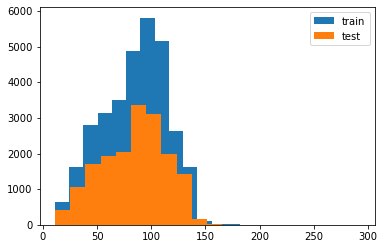

In [7]:
plt.hist(train.tweet.str.len(), bins=20, label='train')
plt.hist(test.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

## Text preprocessing

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [8]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(49159, 3)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [9]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We will be following the steps below to clean the raw tweets in out data.

1. We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

1. We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

1. Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

1. Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

**1. Removing Twitter Handles (@user)**

Let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [10]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here ! i'm it's so #gr8 !


**2. Removing Punctuations, Numbers, and Special Characters**

Here we will replace everything except characters and hashtags with spaces. The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [11]:
combi.tidy_tweet = combi.tidy_tweet.str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare and big talking before they leave chaos and pay disputes when they get there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams can t think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won love the land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here i m it s so #gr


**3. Removing Short Words**

We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [12]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fare talking before they leave chaos disputes when they there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exams think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

**4. Text Normalization (stemming)**

Here we will use nltk’s `PorterStemmer()` function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [13]:
tokenized_tweet = combi.tidy_tweet.apply(lambda x: x.split())
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [14]:
# Now we can normalize the tokenized tweets.

from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [15]:
# Now let’s stitch these tokens back together.

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fare talk befor they leav chao disput when they there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camp tomorrow danni
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think about that #school #exam #hate #imagin #actorslif #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land #allin #cav #champion #cleveland #clevelandcavali
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcom here


In this section, we will explore the cleaned tweets. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Do not limit yourself to only these methods told in this course, feel free to explore the data as much as possible.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

* What are the most common words in the entire dataset?
* What are the most common words in the dataset for negative and positive tweets, respectively?
* How many hashtags are there in a tweet?
* Which trends are associated with my dataset?
* Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

**A) Understanding the common words used in the tweets: WordCloud**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

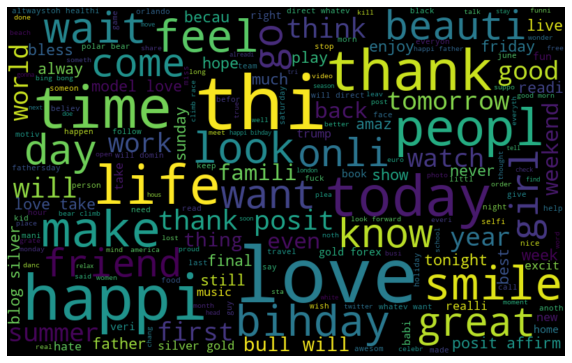

In [16]:
all_words = ' '.join([text for text in combi['tidy_tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

**B) Words in non racist/sexist tweets**

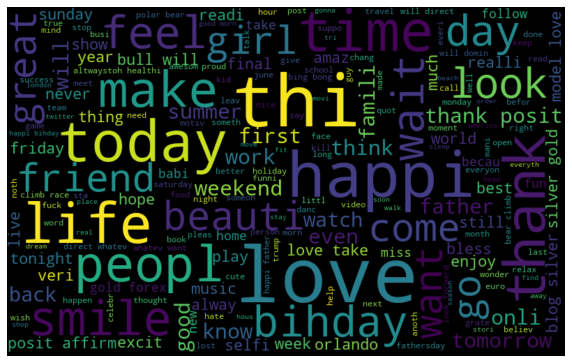

In [17]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

**C) Racist/Sexist Tweets**

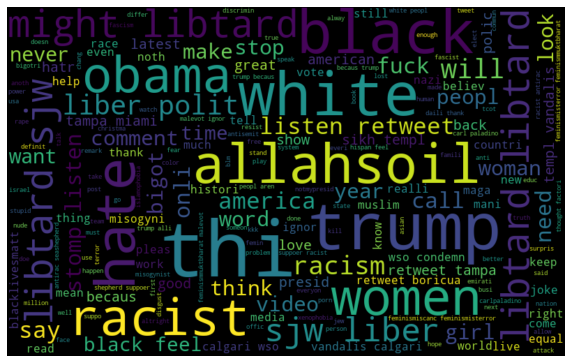

In [18]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

**D) Understanding the impact of Hashtags on tweets sentiment**

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

![imgur](https://i.imgur.com/phLSlwB.png)

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.


In [19]:
# function to collect hashtags 

def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [20]:
# extracting hashtags from non racist/sexist tweets 

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0]) 

In [21]:
# extracting hashtags from racist/sexist tweets

HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1]) 

In [22]:
# unnesting list

HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top ‘n’ hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

**Non-Racist/Sexist Tweets**

In [23]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

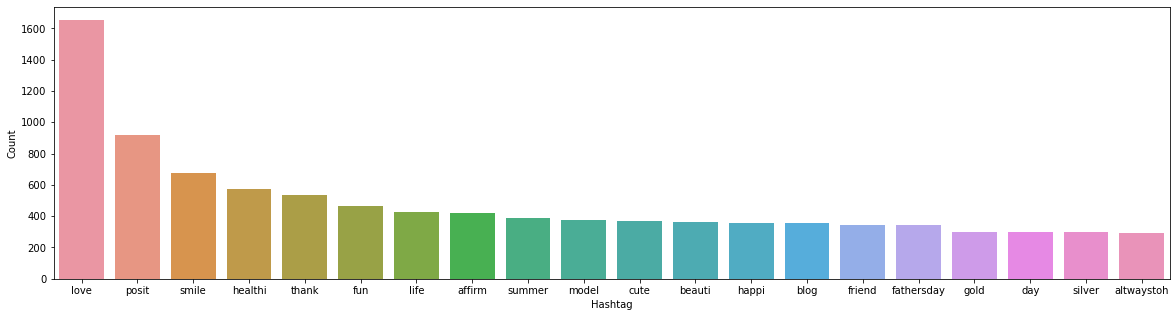

In [24]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

**Racist/Sexist Tweets**

In [25]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

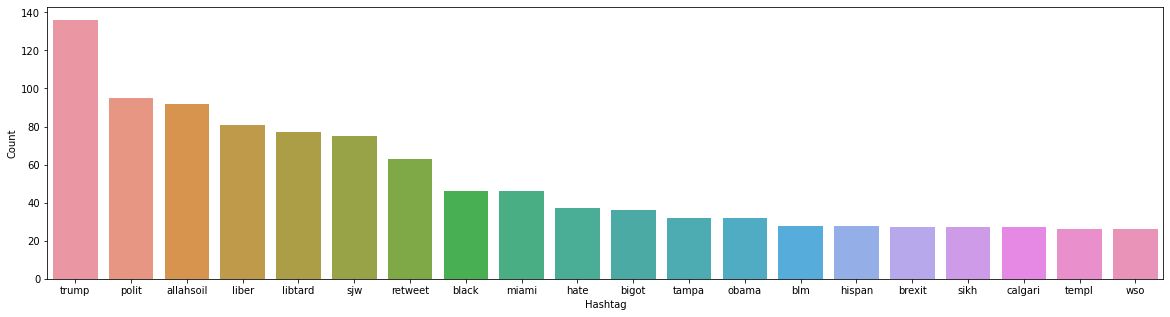

In [26]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

#### Bag-of-Words Features

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings. Read on to understand these techniques in detail.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

Let’s start with the **Bag-of-Words** Features.

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

Let us understand this using a simple example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –
![imgur](https://i.imgur.com/mKcTPdZ.png)

Now the columns in the above matrix can be used as features to build a classification model.

In [28]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

#### TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

* TF = (Number of times term t appears in a document)/(Number of terms in the document)

* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

* TF-IDF = TF*IDF

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

#### Word2Vec Features

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like **King -man +woman = Queen**, which is mind-blowing.

![imgur](https://i.imgur.com/gZiNamE.png)

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

1. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

**Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram** model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.

![imgur](https://i.imgur.com/f77V0dH.png)

There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

* It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

* Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using **pre-trained word vectors** instead of training our own model. Some of the freely available pre-trained vectors are:

1. [Google News Word Vectors](https://code.google.com/archive/p/word2vec/)

1. [Freebase names](https://code.google.com/archive/p/word2vec/)

1. [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec#prebuilt-models)

However, for now, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.

In [30]:
%%time

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

CPU times: user 3min 8s, sys: 967 ms, total: 3min 9s
Wall time: 54.9 s


(6510606, 7536020)

Let’s play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [31]:
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.5735569596290588),
 ('gown', 0.5477359890937805),
 ('noodl', 0.5396475195884705),
 ('#avocado', 0.5385671854019165),
 ('cookout', 0.5358351469039917),
 ('kayak', 0.5297114849090576),
 ('dess', 0.5236117243766785),
 ('#toast', 0.5228814482688904),
 ('#biall', 0.5222061276435852),
 ('aladdin', 0.5175412893295288)]

In [32]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.564525306224823),
 ('phoni', 0.5195056796073914),
 ('hillari', 0.5128163695335388),
 ('tomlin', 0.5125545859336853),
 ('businessman', 0.507940411567688),
 ('potu', 0.5068773031234741),
 ('#delegaterevolt', 0.5040832161903381),
 ('nomine', 0.5036808252334595),
 ('unstabl', 0.50144362449646),
 ('melo', 0.4985101819038391)]

In [33]:
model_w2v.wv.most_similar(negative='love')

[('bihdayjudygarland', 0.0063715786673128605),
 ('finger', -0.0018776634242385626),
 ('#viral', -0.005324105266481638),
 ('#social', -0.015877192839980125),
 ('leak', -0.018011296167969704),
 ('#trump', -0.019467726349830627),
 ('invas', -0.023721998557448387),
 ('board', -0.024107616394758224),
 ('team', -0.02513642981648445),
 ('#upset', -0.02773236483335495)]

In [34]:
model_w2v.wv.most_similar(negative='hate')

[('#kings#queen#streetstyle#sneakernews#smile#basketball#hypebeast#highsnobiety#picoftheday',
  0.10995228588581085),
 ('#fitfam', 0.03067770041525364),
 ('#market', 0.01907019317150116),
 ('#sushi', 0.010414199903607368),
 ('#retro', 0.010302579030394554),
 ('clock', 0.007321422453969717),
 ('#delici', 0.0031534996815025806),
 ('#job', 0.0029595172964036465),
 ('#dinner', 0.002258692868053913),
 ('lunch', -0.0005633659311570227)]

In [35]:
model_w2v.wv.most_similar(positive='narendra')   # it will return error because 'narendra' is not in the vocab

KeyError: "Key 'narendra' not present in vocabulary"

From the above two examples, we can see that our word2vec model does a good job of finding the most similar words for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and it uses cosine similarity to find out the most similar vectors (words).

Let’s check the vector representation of any word from our corpus.

In [36]:
model_w2v.wv['food']

array([ 2.20469013e-02,  1.00517303e-01, -3.10979337e-01, -3.98581415e-01,
       -1.89830735e-01,  1.82577997e-01, -2.65529841e-01, -6.62396669e-01,
        1.33072242e-01, -1.13907194e+00,  4.15336266e-02, -2.70016074e-01,
       -7.17984974e-01,  2.19691690e-04, -4.27143097e-01,  1.22390911e-01,
        3.30035120e-01, -3.24625820e-01,  1.30822763e-01, -1.76918358e-02,
       -7.82689154e-01,  9.88103509e-01,  1.81201741e-01,  6.08720243e-01,
       -2.59735167e-01, -1.74117327e-01, -6.49649620e-01, -3.58360559e-01,
        2.86769748e-01,  2.62802362e-01,  6.97958052e-01, -3.18876565e-01,
        4.29572016e-01, -9.63594839e-02,  2.64335006e-01, -4.68800008e-01,
        3.32269490e-01,  3.95708978e-01,  5.48065424e-01, -4.14030790e-01,
       -6.06084764e-01,  3.22229683e-01, -3.58541548e-01,  4.98703241e-01,
       -2.77937800e-01, -3.73577207e-01,  3.71473730e-01,  3.55223835e-01,
       -1.29893780e+00,  9.72637627e-03, -2.45756209e-01, -7.35600054e-01,
       -3.90835069e-02,  

In [37]:
len(model_w2v.wv['food']) #The length of the vector is 200

200

#### Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [38]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec feature set…

In [39]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF and word2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
1. Support Vector Machine
1. RandomForest
1. XGBoost

**Evaluation Metric**

**F1 score** is being used as the evaluation metric. It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

The important components of F1 score are:

1. True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
1. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
1. False Positives (FP) – When actual class is no and predicted class is yes.
1. False Negatives (FN) – When actual class is yes but predicted class in no.

**Precision** = TP/TP+FP

**Recall** = TP/TP+FN

**F1 Score** = 2(Recall * Precision) / (Recall + Precision)

In [40]:
bow_scores = []
tf_idf_scores = []
word2vec_scores = []

#### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

**Bag-of-Words Features**

We will first try to fit the logistic regression model on the Bag-of-Words (BoW) features.

In [42]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 

# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(xtrain_bow, ytrain)

# predicting on the validation set 
prediction = lreg.predict_proba(xvalid_bow)

prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5303408146300915

In [43]:
bow_scores.append(np.round(f1_score(yvalid, prediction_int),3))

**TF-IDF Features**

We’ll follow the same steps as above, but now for the TF-IDF feature set.

In [44]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:] 

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain) 

prediction = lreg.predict_proba(xvalid_tfidf)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5451327433628319

In [45]:
tf_idf_scores.append(np.round(f1_score(yvalid, prediction_int),3))

**Word2Vec Features**

In [46]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain) 

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.6187683284457478

In [47]:
word2vec_scores.append(np.round(f1_score(yvalid, prediction_int),3))

#### Support Vector Machine (SVM)

In [48]:
from sklearn import svm

**Bag-of-Words Features**

In [49]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5096952908587258

In [50]:
bow_scores.append(np.round(f1_score(yvalid, prediction_int),3))

Here validation score is lesser than the Logistic Regression score for bag-of-words features.

**TF-IDF Features**

In [51]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5104831358249772

In [52]:
tf_idf_scores.append(np.round(f1_score(yvalid, prediction_int),3))

**Word2Vec Features**

In [53]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.6205287713841369

In [54]:
word2vec_scores.append(np.round(f1_score(yvalid, prediction_int),3))

#### RandomForest

In [55]:
from sklearn.ensemble import RandomForestClassifier

**Bag-of-Words Features**

First we will train our RandomForest model on the Bag-of-Words features and check its performance on validation set.

In [56]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
f1_score(yvalid, prediction) # validation score

0.5529225908372828

In [57]:
bow_scores.append(np.round(f1_score(yvalid, prediction),3))

**TF-IDF Features**

In [58]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.562152133580705

In [59]:
tf_idf_scores.append(np.round(f1_score(yvalid, prediction),3))

**Word2Vec Features**

In [60]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.4972972972972974

In [61]:
word2vec_scores.append(np.round(f1_score(yvalid, prediction),3))

#### XGBoost

In [62]:
from xgboost import XGBClassifier

**Bag-of-Words Features**

In [63]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5247706422018349

In [64]:
bow_scores.append(np.round(f1_score(yvalid, prediction),3))

**TF-IDF Features**

In [65]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5394265232974911

In [66]:
tf_idf_scores.append(np.round(f1_score(yvalid, prediction),3))

**Word2Vec Features**

In [67]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.6560283687943264

In [68]:
word2vec_scores.append(np.round(f1_score(yvalid, prediction),3))

XGBoost model on word2vec features has outperformed all the previuos models

#### Performance comparision

In [69]:
performance = pd.DataFrame(data=zip(bow_scores, tf_idf_scores, word2vec_scores), 
                           columns=['BOW', 'TF-IDF', 'Wrod2Vec'],
                           index=['Logistic Regression', 'SVM (linear)', 'Random Forest', 'XGBoost']
                          )

In [70]:
performance

,BOW,TF-IDF,Wrod2Vec
Logistic Regression,0.530,0.545,0.619
SVM (linear),0.510,0.510,0.621
Random Forest,0.553,0.562,0.497
XGBoost,0.525,0.539,0.656


#### FineTuning XGBoost + Word2Vec

XGBoost with Word2Vec model has given us the best performance so far. Let’s try to tune it further to extract as much from it as we can. XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. This is what we are going to do in the following steps. You can refer this guide to learn more about parameter tuning in XGBoost.

In [71]:
import xgboost as xgb

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [72]:
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'colsample_bylevel': 1,
    'colsample_bytree': 1
 }

We will prepare a custom evaluation metric to calculate F1 score.

In [73]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

**General Approach for Parameter Tuning**

We will follow the steps below to tune the parameters.

1. Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

1. Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

1. Tune the learning rate.

1. Finally tune gamma to avoid overfitting.

*Tuning max_depth and min_child_weight*

In [74]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(5,8)
    ]

max_f1 = 0. # initializing with 0 

best_params = None 

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))
    
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        custom_metric= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
        )     
    
    # Finding best F1 Score    
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].idxmax()    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    

    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
	F1 Score 0.6778337999999999 for 57 rounds
CV with max_depth=6, min_child_weight=6
	F1 Score 0.6666752 for 46 rounds
CV with max_depth=6, min_child_weight=7
	F1 Score 0.6892438000000001 for 68 rounds
CV with max_depth=7, min_child_weight=5
	F1 Score 0.6630298000000001 for 41 rounds
CV with max_depth=7, min_child_weight=6
	F1 Score 0.6894435999999999 for 101 rounds
CV with max_depth=7, min_child_weight=7
	F1 Score 0.6750324000000001 for 42 rounds
CV with max_depth=8, min_child_weight=5
	F1 Score 0.6727588 for 37 rounds
CV with max_depth=8, min_child_weight=6
	F1 Score 0.6747638 for 60 rounds
CV with max_depth=8, min_child_weight=7
	F1 Score 0.6782394 for 59 rounds
CV with max_depth=9, min_child_weight=5
	F1 Score 0.6750944 for 54 rounds
CV with max_depth=9, min_child_weight=6
	F1 Score 0.676839 for 65 rounds
CV with max_depth=9, min_child_weight=7
	F1 Score 0.6778658 for 53 rounds
Best params: 7, 6, F1 Score: 0.6894435999999999


Updating max_depth and min_child_weight parameters.

In [77]:
params['max_depth'] = 7 
params['min_child_weight'] = 6

Tuning *colsample_bylevel* and *colsample_bytree*

In [78]:
gridsearch_params = [
    (colsample_bylevel, colsample_bytree)
    for colsample_bylevel in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)]
]

max_f1 = 0. 
best_params = None 

for colsample_bylevel, colsample_bytree in gridsearch_params:
    print("CV with colsample_bylevel={}, colsample_bytree={}".format(colsample_bylevel,colsample_bytree))
    
    # Update our parameters
    params['colsample_bylevel'] = colsample_bylevel
    params['colsample_bytree'] = colsample_bytree
    
    cv_results = xgb.cv(
        params,
        dtrain,
        custom_metric= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
        )
    
    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].idxmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (colsample_bylevel,colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with colsample_bylevel=0.5, colsample_bytree=0.5
	F1 Score 0.6734614 for 36 rounds
CV with colsample_bylevel=0.5, colsample_bytree=0.6
	F1 Score 0.6838676 for 67 rounds
CV with colsample_bylevel=0.5, colsample_bytree=0.7
	F1 Score 0.6726822 for 49 rounds
CV with colsample_bylevel=0.5, colsample_bytree=0.8
	F1 Score 0.6768698 for 68 rounds
CV with colsample_bylevel=0.5, colsample_bytree=0.9
	F1 Score 0.682145 for 42 rounds
CV with colsample_bylevel=0.6, colsample_bytree=0.5
	F1 Score 0.6816350000000001 for 66 rounds
CV with colsample_bylevel=0.6, colsample_bytree=0.6
	F1 Score 0.6828511999999999 for 85 rounds
CV with colsample_bylevel=0.6, colsample_bytree=0.7
	F1 Score 0.6799938 for 60 rounds
CV with colsample_bylevel=0.6, colsample_bytree=0.8
	F1 Score 0.680968 for 42 rounds
CV with colsample_bylevel=0.6, colsample_bytree=0.9
	F1 Score 0.6742362 for 46 rounds
CV with colsample_bylevel=0.7, colsample_bytree=0.5
	F1 Score 0.6876364 for 77 rounds
CV with colsample_bylevel=0.7, colsamp

Updating *subsample* and *colsample_bytree*

In [79]:
params['colsample_bylevel'] = 0.7
params['colsample_bytree'] = 0.8

Now let’s tune the *learning rate*.

In [80]:
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    params['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        custom_metric= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].idxmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
        
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3
	F1 Score 0.6936815999999999 for 111 rounds
CV with eta=0.2
	F1 Score 0.6975758 for 163 rounds
CV with eta=0.1
	F1 Score 0.6911596 for 183 rounds
CV with eta=0.05
	F1 Score 0.6950783999999999 for 263 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.2, F1 Score: 0.6975758


In [81]:
params['eta'] = 0.2

Let’s have a look at the final list of tuned parameters.

In [82]:
print(params)

{'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.2, 'colsample_bylevel': 0.7, 'colsample_bytree': 0.8}


Finally we can now use these tuned parameters in our xgboost model. We have used early stopping of 10 which means if the model’s performance doesn’t improve under 10 rounds, then the model training will be stopped.

In [83]:
xgb_model = xgb.train(
    params,
    dtrain,
    custom_metric= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[0]	Validation-logloss:0.54697	Validation-f1_score:0.13317
[1]	Validation-logloss:0.44887	Validation-f1_score:0.13317
[2]	Validation-logloss:0.37876	Validation-f1_score:0.38682
[3]	Validation-logloss:0.32597	Validation-f1_score:0.48410
[4]	Validation-logloss:0.28607	Validation-f1_score:0.53059
[5]	Validation-logloss:0.25536	Validation-f1_score:0.55356
[6]	Validation-logloss:0.23107	Validation-f1_score:0.56535
[7]	Validation-logloss:0.21209	Validation-f1_score:0.57583
[8]	Validation-logloss:0.19698	Validation-f1_score:0.58064
[9]	Validation-logloss:0.18561	Validation-f1_score:0.58466
[10]	Validation-logloss:0.17567	Validation-f1_score:0.58623
[11]	Validation-logloss:0.16760	Validation-f1_score:0.59530
[12]	Validation-logloss:0.16133	Validation-f1_score:0.59416
[13]	Validation-logloss:0.15657	Validation-f1_score:0.60082
[14]	Validation-logloss:0.15204	Validation-f1_score:0.60439
[15]	Validation-logloss:0.14860	Validation-f1_score:0.60735
[16]	Validation-logloss:0.14558	Validation-f1_scor

In [84]:
prediction = xgb_model.predict(dvalid)
prediction = (prediction >= 0.3).astype(np.int)
f1_score(yvalid, prediction)

0.6650406504065041

Our tuning worked! This is our best score!!

### Conclusion

Word2Vec features turned out to be most useful. Whereas **XGBoost with Word2Vec features** was the best model for this problem. This clearly shows the power of word embeddings in dealing with NLP problems.